In [ ]:
!python --version

Python 3.11.12


#Mounting and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F

#Reload Model and Register Custom Layers

In [ ]:

# ---------------------
# 1️⃣ Reload your saved model
# ---------------------
@tf.keras.utils.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return inputs[:, :, self.index]

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SqueezeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.squeeze(inputs, axis=-1)

In [ ]:
@tf.keras.utils.register_keras_serializable()
def r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())


In [ ]:
# Load model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/XAI/final_transformer_model.keras",
    custom_objects={
        'r2_score': r2_score,
        'PositionalEncoding': PositionalEncoding,
        'SliceLayer': SliceLayer,
        'SqueezeLayer': SqueezeLayer
    }
)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_2       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_3       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 12, 8)     │        800 │ slice_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 8)     │        800 │ slice_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 8)     │        800 │ slice_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 12, 8)     │        800 │ slice_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 32)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12, 38)    │          0 │ concatenate[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 64)    │      2,496 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 12, 64)    │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 64)    │          0 │ positional_encod

 Total params: 516,485 (1.97 MB)

 Trainable params: 172,161 (672.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 344,324 (1.31 MB)

# Extract and Build Embedding Submodel
To extract the embeddings (vectors) of the categorical features from the original model.

In [ ]:
# Step 2: Identify embedding layers in your model
embedding_layers = []
for layer in model.layers:
    if "embedding" in layer.name.lower():
        embedding_layers.append(layer)

print("Found embedding layers:", [layer.name for layer in embedding_layers])

Found embedding layers: ['embedding', 'embedding_1', 'embedding_2', 'embedding_3']


In [ ]:
"""
Build a submodel that outputs the concatenated embeddings
Create a new Keras model that:
 -Takes the same inputs as your full model (cat_inputs and num_inputs).
 -Outputs the concatenated embeddings (before combining with numerical features).
"""
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

# Step 2: Extract model inputs
cat_input = model.input[0]  # (batch, 12, 4)
num_input = model.input[1]  # (batch, 12, 6)

# Step 3: Slice each categorical column & pass through the correct embedding
slice_layers = []
for i in range(4):
    slice_layer = None
    for layer in model.layers:
        if isinstance(layer, SliceLayer) and layer.index == i:
            slice_layer = layer
            break
    if slice_layer is None:
        raise ValueError(f"SliceLayer for index {i} not found.")
    slice_layers.append(slice_layer)

# Pass slices through corresponding embeddings
embed_outputs = []
for i in range(4):
    cat_col = slice_layers[i](cat_input)
    embedded = embedding_layers[i](cat_col)
    embed_outputs.append(embedded)

# Concatenate all embeddings
concat_embed = Concatenate(axis=-1)(embed_outputs)  # shape (batch, 12, 32) → 4 embeddings × 8 dims each

# Step 4: Create the submodel
embedding_submodel = Model(
    inputs=[cat_input, num_input],
    outputs=concat_embed
)

embedding_submodel.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_2       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_3       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 12, 8)     │        800 │ slice_layer[1][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 8)     │        800 │ slice_layer_1[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 8)     │        800 │ slice_layer_2[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 12, 8)     │        800 │ slice_layer_3[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 32)    │          0 │ embedding[1][0],  │
│ (Concatenate)       │                   │            │ embedding_1[1][0… │
│                     │                   │            │ embedding_2[1][0… │
│                     │                   │            │ embedding_3[1][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,200 (12.50 KB)

 Trainable params: 3,200 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

#Compute Integrated Gradients on Embeddings

In [ ]:
"""
Compute Integrated Gradients on the embeddings
  -Interpolate between a baseline embedding (all zeros) and the actual embedding.
  -Compute gradients of the final model prediction with respect to the embeddings.
  -That tells us how much each embedding dimension (and therefore each categorical feature) contributed to the prediction!
"""
def compute_integrated_gradients_on_embeddings(model,embedding_submodel,cat_input,num_input,target_index=None,m_steps=50):
    # 1️⃣ Get actual embeddings for input
    embed_actual = embedding_submodel([cat_input, num_input])

    # 2️⃣ Define baseline (zero embeddings)
    baseline_embed = tf.zeros_like(embed_actual)

    # 3️⃣ Interpolate between baseline and actual embeddings
    alphas = tf.linspace(0.0, 1.0, m_steps + 1)
    interpolated_embeds = [baseline_embed + alpha * (embed_actual - baseline_embed) for alpha in alphas]
    interpolated_embeds = tf.concat(interpolated_embeds, axis=0)  # shape: (m_steps+1, 12, 32)

    # 4️⃣ Repeat numerical input for all alphas
    interpolated_num = tf.repeat(num_input, repeats=m_steps + 1, axis=0)

    # 5️⃣ Compute gradients wrt embeddings
    with tf.GradientTape() as tape:
        tape.watch(interpolated_embeds)

        # Pass embeddings forward through the rest of the model
        # NOTE: We'll need to create a submodel that takes embeddings + num_input as input
        preds = model_from_embeddings([interpolated_embeds, interpolated_num])

        if target_index is not None:
            preds = preds[:, target_index]

    grads = tape.gradient(preds, interpolated_embeds)

    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (embed_actual - baseline_embed) * avg_grads

    return integrated_grads.numpy()  # shape (12, 32)


#Create New Model That Accepts Embeddings
To extract the embeddings (vectors) of the categorical features from the original model.


*   new model skips the embedding step (already done)
*   You apply the same transformer logic here (multi-head attention + feedforward blocks) as in training.

This model now mimics the rest of your original model, but takes:

*   [embeddings, numerical input] → prediction.

In [ ]:
"""
Before we can run this function, we need a submodel that:
 -Takes embedding tensor + numerical input → outputs predictions.
 -Because your full model expects categorical indices and does the embedding internally.
 -But now, we already have the embeddings, so we need to bypass the embedding layers and pass those embeddings directly to the remaining layers.

We need to create a new Keras submodel that takes:
     Inputs → embeddings (shape: batch_size × 12 × 32)
     And → numerical input (shape: batch_size × 12 × 6)
Feeds them through the rest of your model (skipping the embedding layers).
Outputs the predictions.
"""
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Lambda
# Step 4: Create new model input layers
embed_input = tf.keras.Input(shape=(12, 32), name="embed_input")  # 4 embeddings × 8 dims = 32
num_input2 = tf.keras.Input(shape=(12, 6), name="num_input")

# Step 5: Concatenate embeddings + numerical features
x = Concatenate(axis=-1)([embed_input, num_input2])  # Shape: (batch, 12, 38)

# Step 6: Project to d_model
d_model = 128  # Same as original model
x = Dense(d_model)(x)

# Positional encoding already baked in, so we skip adding it again.

# Step 7: Transformer encoder layers
num_layers = 2
num_heads = 4
ff_dim = 256
dropout_rate = 0.1

for _ in range(num_layers):
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feed-forward network
    ffn = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(d_model)
    ])
    ffn_output = ffn(x)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

# Step 8: Output layer
output = Dense(1)(x)  # shape (batch, 12, 1)
# output = tf.squeeze(output, axis=-1)  # shape (batch, 12)
output = Lambda(lambda x: tf.squeeze(x, axis=-1))(output)
# Step 9: Build the new model
model_from_embeddings = Model(
    inputs=[embed_input, num_input2],
    outputs=output
)

model_from_embeddings.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embed_input         │ (None, 12, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12, 38)    │          0 │ embed_input[0][0… │
│ (Concatenate)       │                   │            │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 128)   │      4,992 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 128)   │    263,808 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 12, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 128)   │          0 │ dense[0][0],      │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 12, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 12, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 12, 128)   │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 12, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 12, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 12, 128)   │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 665,601 (2.54 MB)

 Trainable params: 665,601 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

#Load Data

In [ ]:
# ---------------------
# 2️⃣ Reload your Parquet data
# ---------------------

zip_file_path = '/content/drive/MyDrive/preprocessingForSingleTimeSeries/sequenced_for_single_model.zip'
extract_path = '/content/extracted_data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

spark = SparkSession.builder \
    .appName("GHGEmissionsForecasting") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

In [ ]:
full_df = spark.read.parquet(extract_path)

#Prepare one batch from dataset

In [ ]:
# ---------------------
# 3️⃣ Prepare one batch from the test set
# ---------------------

sequence_length = 12
categorical_index_cols = ["iso3_country_index", "sector_index", "subsector_index", "gas_index"]
numerical_feature_columns = ["lat_scaled", "lon_scaled", "duration_scaled", "start_year_scaled", "start_month_sin", "start_month_cos"]

def extract_batch(df, n_samples=1):
    cat_seqs = []
    num_seqs = []
    target_seqs = []

    # rows = df.limit(n_samples).collect()
    rows = df.orderBy("iso3_country_index", "sector_index", "subsector_index", "gas_index").limit(n_samples).collect()


    for row in rows:
        cat_seq = []
        num_seq = []

        for timestep in row["feature_sequence"]:
            cat_features = np.array([
                timestep["iso3_country_index"],
                timestep["sector_index"],
                timestep["subsector_index"],
                timestep["gas_index"]
            ], dtype=np.int32)

            num_features = np.array([
                timestep["lat_scaled"],
                timestep["lon_scaled"],
                timestep["duration_scaled"],
                timestep["start_year_scaled"],
                timestep["start_month_sin"],
                timestep["start_month_cos"]
            ], dtype=np.float32)

            cat_seq.append(cat_features)
            num_seq.append(num_features)

        cat_seqs.append(np.array(cat_seq))
        num_seqs.append(np.array(num_seq))
        target_seqs.append(np.array(row["target_sequence"]))

    return np.array(cat_seqs), np.array(num_seqs), np.array(target_seqs)

Filter the most recent year for test sampling

In [ ]:
# Get the latest year for testing
test_year = full_df.select("start_year").distinct().orderBy("start_year", ascending=False).collect()[0]['start_year']
test_df = full_df.filter(F.col("start_year") == test_year)

cat_batch, num_batch, target_batch = extract_batch(test_df, n_samples=1)

print("Categorical input shape:", cat_batch.shape)
print("Numerical input shape:", num_batch.shape)
print("Target shape:", target_batch.shape)

Categorical input shape: (1, 12, 4)
Numerical input shape: (1, 12, 6)
Target shape: (1, 12)


In [ ]:
# Example: compute IG for timestep 0 (first month)
timestep = 0

ig_embeddings = compute_integrated_gradients_on_embeddings(
    model,
    embedding_submodel,
    cat_batch,
    num_batch,
    target_index=timestep,
    m_steps=50
)


print("Integrated Gradients shape:", ig_embeddings.shape)

Integrated Gradients shape: (1, 12, 32)


In [ ]:
ig_embeddings = ig_embeddings[0]  # Shape now (12, 32)
print("Integrated Gradients shape:", ig_embeddings.shape)

Integrated Gradients shape: (12, 32)


#Visualize Attribution Over Time by Category

In [ ]:
# Remove batch dimension
if len(ig_embeddings.shape) == 3:
    ig_embeddings = ig_embeddings[0]

# Split attributions
ig_iso3 = ig_embeddings[:, 0:8]
ig_sector = ig_embeddings[:, 8:16]
ig_subsector = ig_embeddings[:, 16:24]
ig_gas = ig_embeddings[:, 24:32]

print("iso3_country_index shape:", ig_iso3.shape)
print("sector_index shape:", ig_sector.shape)
print("subsector_index shape:", ig_subsector.shape)
print("gas_index shape:", ig_gas.shape)


iso3_country_index shape: (12, 8)
sector_index shape: (12, 8)
subsector_index shape: (12, 8)
gas_index shape: (12, 8)


In [ ]:
iso3_importance = np.sum(ig_iso3, axis=1)    # Shape (12,)
sector_importance = np.sum(ig_sector, axis=1) # Shape (12,)
subsector_importance = np.sum(ig_subsector, axis=1)
gas_importance = np.sum(ig_gas, axis=1)

# Combine into DataFrame for easy plotting
import pandas as pd

df_cat_ig = pd.DataFrame({
    "Month": [f"Month {i+1}" for i in range(12)],
    "iso3_country_index": iso3_importance,
    "sector_index": sector_importance,
    "subsector_index": subsector_importance,
    "gas_index": gas_importance
})

print(df_cat_ig)


       Month  iso3_country_index  sector_index  subsector_index  gas_index
0    Month 1            0.116134      0.717412         0.131540  -0.427963
1    Month 2           -0.003768     -0.000187         0.005239  -0.008038
2    Month 3           -0.004774     -0.004217         0.007323  -0.006637
3    Month 4           -0.003305      0.000179        -0.004358  -0.009178
4    Month 5           -0.003305      0.000179        -0.004358  -0.009178
5    Month 6           -0.003305      0.000179        -0.004358  -0.009178
6    Month 7           -0.003305      0.000179        -0.004358  -0.009178
7    Month 8           -0.003305      0.000179        -0.004358  -0.009178
8    Month 9           -0.003305      0.000179        -0.004358  -0.009178
9   Month 10           -0.003305      0.000179        -0.004358  -0.009178
10  Month 11           -0.003305      0.000179        -0.004358  -0.009178
11  Month 12           -0.003305      0.000179        -0.004358  -0.009178


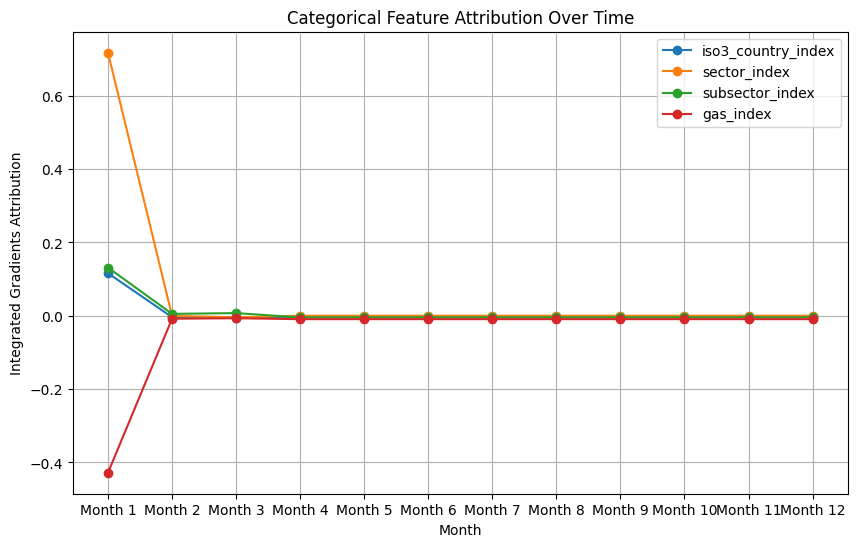

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for col in ["iso3_country_index", "sector_index", "subsector_index", "gas_index"]:
    plt.plot(df_cat_ig["Month"], df_cat_ig[col], marker='o', label=col)

plt.title("Categorical Feature Attribution Over Time")
plt.ylabel("Integrated Gradients Attribution")
plt.xlabel("Month")
plt.legend()
plt.grid(True)
plt.show()


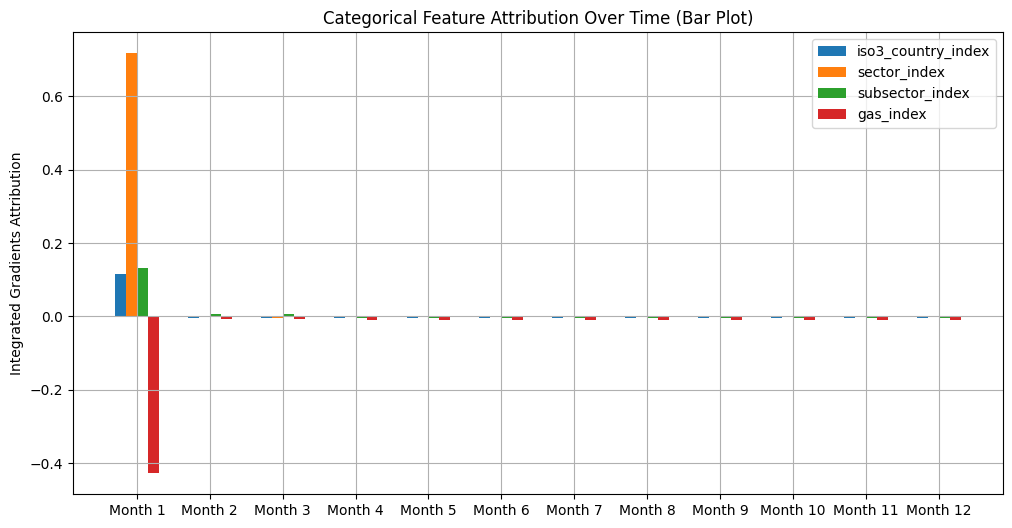

In [ ]:
plt.figure(figsize=(12, 6))
bar_width = 0.15

months = np.arange(12)

for i, feature in enumerate(["iso3_country_index", "sector_index", "subsector_index", "gas_index"]):
    plt.bar(
        months + i * bar_width,
        df_cat_ig[feature],
        width=bar_width,
        label=feature
    )

plt.xticks(months + 1.5 * bar_width, [f"Month {i+1}" for i in range(12)])
plt.ylabel("Integrated Gradients Attribution")
plt.title("Categorical Feature Attribution Over Time (Bar Plot)")
plt.legend()
plt.grid(True)
plt.show()


#Map Back to Actual Category Names

In [ ]:
# Sum absolute attributions for each embedding dimension per timestep
ig_iso3_abs = np.abs(ig_iso3)  # Shape (12, 8)

# For each timestep, find which country dimension contributed most
top_country_dims = np.argmax(ig_iso3_abs, axis=1)

print("Most important country embedding dimension per month:", top_country_dims)


Most important country embedding dimension per month: [4 4 7 7 7 7 7 7 7 7 7 7]


In [ ]:
country_indices = cat_batch[0, :, 0]  # Batch 0, all timesteps, iso3_country_index column

print("Country indices in batch:", country_indices) # Will be the same since it is from the same country


Country indices in batch: [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
country_mapping = {
    0: "IND",
    1: "BGD",
    2: "AFG",
    3: "LKA",
    4: "PAK",
    5: "BTN",
    6: "NPL",
    7: "MDV"
}

country_names = [country_mapping[int(idx)] for idx in country_indices]
print("Country names per month:", country_names)


Country names per month: ['IND', 'IND', 'IND', 'IND', 'IND', 'IND', 'IND', 'IND', 'IND', 'IND', 'IND', 'IND']


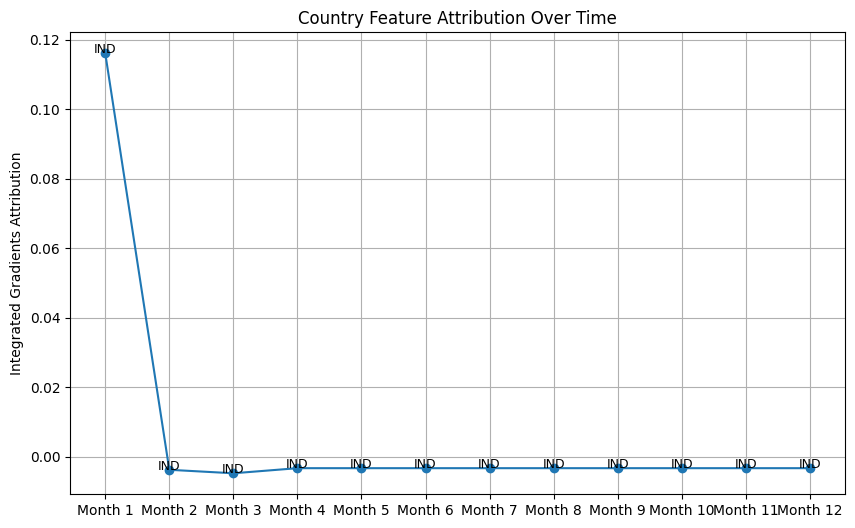

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([f"Month {i+1}" for i in range(12)], np.sum(ig_iso3, axis=1), marker='o')
for i, name in enumerate(country_names):
    plt.text(i, np.sum(ig_iso3[i]), name, fontsize=9, ha='center')

plt.title("Country Feature Attribution Over Time")
plt.ylabel("Integrated Gradients Attribution")
plt.grid(True)
plt.show()


In [ ]:
sector_indices = cat_batch[0, :, 1]  # Sector index
sector_mapping = {
    0: "agriculture",
    1: "forestry-and-land-use",
    2: "buildings",
    3: "transportation",
    4: "manufacturing",
    5: "waste",
    6: "power",
    7: "fossil-fuel-operations",
    8: "mineral-extraction"
}

sector_names = [sector_mapping[int(idx)] for idx in sector_indices]
print("Sector names per month:", sector_names)


Sector names per month: ['agriculture', 'forestry-and-land-use', 'transportation', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use', 'forestry-and-land-use']


In [ ]:
import json
# Load label mappings
json_path = '/content/drive/MyDrive/XAI/label_encoding_index_mappings.json'
with open(json_path, 'r') as f:
    category_mappings = json.load(f)

In [ ]:
category_mappings

{'iso3_country': {'IND': 0,
  'BGD': 1,
  'AFG': 2,
  'LKA': 3,
  'PAK': 4,
  'BTN': 5,
  'NPL': 6,
  'MDV': 7},
 'sector': {'agriculture': 0,
  'forestry-and-land-use': 1,
  'buildings': 2,
  'transportation': 3,
  'manufacturing': 4,
  'waste': 5,
  'power': 6,
  'fossil-fuel-operations': 7,
  'mineral-extraction': 8},
 'subsector': {'rice-cultivation': 0,
  'road-transportation': 1,
  'textiles-leather-apparel': 2,
  'synthetic-fertilizer-application': 3,
  'enteric-fermentation-cattle-pasture': 4,
  'manure-left-on-pasture-cattle': 5,
  'residential-onsite-fuel-usage': 6,
  'non-residential-onsite-fuel-usage': 7,
  'removals': 8,
  'cropland-fires': 9,
  'net-shrubgrass': 10,
  'net-forest-land': 11,
  'net-wetland': 12,
  'electricity-generation': 13,
  'forest-land-clearing': 14,
  'shrubgrass-fires': 15,
  'forest-land-degradation': 16,
  'forest-land-fires': 17,
  'domestic-wastewater-treatment-and-discharge': 18,
  'wetland-fires': 19,
  'solid-waste-disposal': 20,
  'coal-min

In [ ]:
# ---------------------
# 1️⃣ Mappings (from your JSON file)
# ---------------------

# Reverse the mappings
country_mapping = {v: k for k, v in category_mappings['iso3_country'].items()}
sector_mapping = {v: k for k, v in category_mappings['sector'].items()}
subsector_mapping = {v: k for k, v in category_mappings['subsector'].items()}
gas_mapping = {v: k for k, v in category_mappings['gas'].items()}


# ---------------------
# 2️⃣ Extract indices from cat_batch
# ---------------------

country_indices = cat_batch[0, :, 0]
sector_indices = cat_batch[0, :, 1]
subsector_indices = cat_batch[0, :, 2]
gas_indices = cat_batch[0, :, 3]

# ---------------------
# 3️⃣ Map indices to names
# ---------------------

country_names = [country_mapping[int(idx)] for idx in country_indices]
sector_names = [sector_mapping[int(idx)] for idx in sector_indices]
subsector_names = [subsector_mapping[int(idx)] for idx in subsector_indices]
gas_names = [gas_mapping[int(idx)] for idx in gas_indices]

# ---------------------
# 4️⃣ Print results
# ---------------------

for t in range(12):
    print(f"Month {t+1}:")
    print(f"  Country   → {country_names[t]}")
    print(f"  Sector    → {sector_names[t]}")
    print(f"  Subsector → {subsector_names[t]}")
    print(f"  Gas       → {gas_names[t]}")
    print("-----------------------------")


Month 1:
  Country   → IND
  Sector    → agriculture
  Subsector → cropland-fires
  Gas       → ch4
-----------------------------
Month 2:
  Country   → IND
  Sector    → forestry-and-land-use
  Subsector → forest-land-degradation
  Gas       → ch4
-----------------------------
Month 3:
  Country   → IND
  Sector    → transportation
  Subsector → road-transportation
  Gas       → ch4
-----------------------------
Month 4:
  Country   → IND
  Sector    → forestry-and-land-use
  Subsector → shrubgrass-fires
  Gas       → ch4
-----------------------------
Month 5:
  Country   → IND
  Sector    → forestry-and-land-use
  Subsector → shrubgrass-fires
  Gas       → ch4
-----------------------------
Month 6:
  Country   → IND
  Sector    → forestry-and-land-use
  Subsector → shrubgrass-fires
  Gas       → ch4
-----------------------------
Month 7:
  Country   → IND
  Sector    → forestry-and-land-use
  Subsector → shrubgrass-fires
  Gas       → ch4
-----------------------------
Month 8:
  Coun

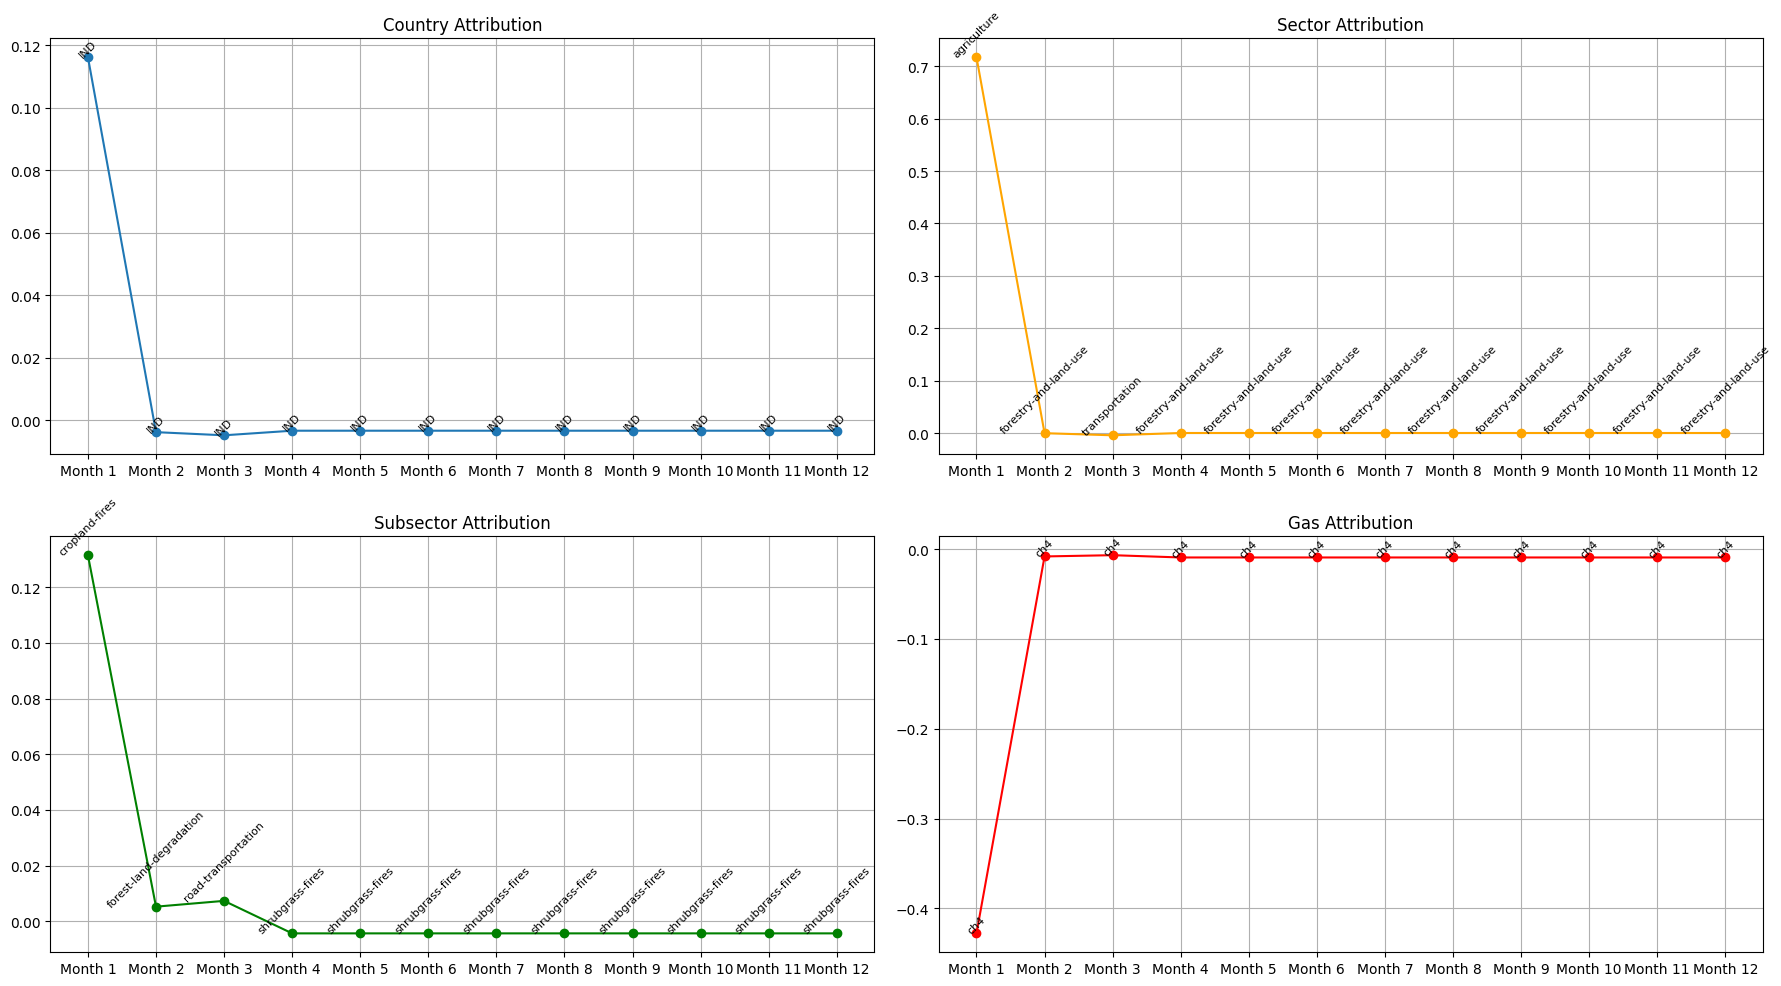

In [ ]:
import matplotlib.pyplot as plt

months = [f"Month {i+1}" for i in range(12)]

plt.figure(figsize=(18, 10))

# -------------------------
# 1️⃣ Country attribution plot
# -------------------------
plt.subplot(2, 2, 1)
plt.plot(months, np.sum(ig_iso3, axis=1), marker='o', label='iso3_country_index')
for i, name in enumerate(country_names):
    plt.text(i, np.sum(ig_iso3, axis=1)[i], name, fontsize=8, ha='center',rotation=45)
plt.title("Country Attribution")
plt.grid(True)

# -------------------------
# 2️⃣ Sector attribution plot
# -------------------------
plt.subplot(2, 2, 2)
plt.plot(months, np.sum(ig_sector, axis=1), marker='o', label='sector_index', color='orange')
for i, name in enumerate(sector_names):
    plt.text(i, np.sum(ig_sector, axis=1)[i], name, fontsize=8, ha='center',rotation=45)
plt.title("Sector Attribution")
plt.grid(True)

# -------------------------
# 3️⃣ Subsector attribution plot
# -------------------------
plt.subplot(2, 2, 3)
plt.plot(months, np.sum(ig_subsector, axis=1), marker='o', label='subsector_index', color='green')
for i, name in enumerate(subsector_names):
    plt.text(i, np.sum(ig_subsector, axis=1)[i], name, fontsize=8, ha='center',rotation=45)
plt.title("Subsector Attribution")
plt.grid(True)

# -------------------------
# 4️⃣ Gas attribution plot
# -------------------------
plt.subplot(2, 2, 4)
plt.plot(months, np.sum(ig_gas, axis=1), marker='o', label='gas_index', color='red')
for i, name in enumerate(gas_names):
    plt.text(i, np.sum(ig_gas, axis=1)[i], name, fontsize=8, ha='center',rotation=45)
plt.title("Gas Attribution")
plt.grid(True)

plt.tight_layout()
plt.show()
